In [1]:
#------------Step0: Import Required Packages-------------
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Embedding, Dropout, Conv1D, MaxPool1D, GRU, LSTM, Dense, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

Using TensorFlow backend.


In [2]:
#------Step1:Data preprocessing-------------
Neg_Data =pd.read_csv("complaint1700 .csv")
NoNeg_Data=pd.read_csv("noncomplaint1700.csv")
#Here I label two kinds of sentiment: negative as 0, non-negative as 1
Neg_Data ['sentiment'] = 0
NoNeg_Data ['sentiment'] = 1
Neg_Data
total_data = pd.concat([Neg_Data,NoNeg_Data],ignore_index=True)

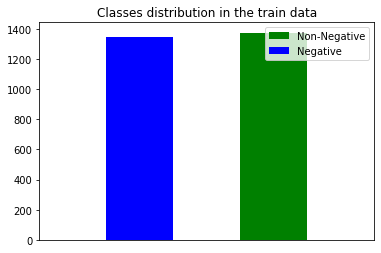

In [3]:
# Split into training (80%) and testing data (20%)
train, test = train_test_split(
    total_data,train_size=0.8,random_state = 8)
#Check the class balance
# see the distribution of 0 VS.1 in train and test (nearly 1:1, balanced dataset)
train.groupby(['sentiment'],as_index=False).agg({'id':'count'})  #1345 VS.1375;
test.groupby(['sentiment'],as_index=False).agg({'id':'count'})  #355 VS. 325

plt.hist(train[train.sentiment == 1].sentiment,
         bins=2, color='green', label='Non-Negative')
plt.hist(train[train.sentiment == 0].sentiment,
         bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data')
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [4]:
# Data Cleaning and Text Preprocessing
# firstly define four pre-processing functions, then combine them into one function for later use!

#clean1: Return input string with only letters (no punctuation, no numbers)
def letters_only(text):
    return re.sub("[^a-zA-Z]", " ", text)

#clean2: lower the data
def clean_review(review):
    return letters_only(html_to_text(review)).lower()

#clean3:lemmatize data
def lemmatize(tokens: list) -> list:
    # 1. Lemmatize
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # 2. Remove stop words
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    return meaningful_words


#clean4: Return extracted text string from provided HTML string.
def html_to_text(review):
    review_text = BeautifulSoup(review, "lxml").get_text()
    if len(review_text) == 0:
        review_text = review
    review_text = re.sub(r"\<.*\>", "", review_text)
    try:
        review_text = review_text.encode('ascii', 'ignore').decode('ascii')
    except UnicodeDecodeError:
        review_text = review_text.decode("ascii", "ignore")
    return review_text

#-----------------for convenience, combine all those four function into one---------------
#Notice：later I will use this combined function to deal submission data (comment in'tweet' column)
def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # 1. Clean text
    review = clean_review(review)
    # 2. Split into individual words
    tokens = word_tokenize(review)
    # 3. Lemmatize
    lemmas = lemmatize(tokens)
    # 4. Join the words back into one string separated by space,
    # and return the result.
    return lemmas

import nltk
nltk.download('stopwords')
counter = 0
REPLACE_WITH_SPACE = re.compile(r'[^A-Za-z\s]')
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /Users/admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
import nltk
nltk.download('wordnet')
all_data = [train, test]

#Note that: use preproceesing function to 'tweet' column, but NOT on the sentiment score!
all_reviews = np.array([], dtype=str)
for dataset in all_data:
    all_reviews = np.concatenate((all_reviews, dataset.tweet), axis=0)
print('Total number of tweets:', len(all_reviews))

#all_reviews wii return to a list(every tweet will have one list): ONLY includes the words which may influence the sentiment score
all_reviews = np.array(list(map(lambda x: preprocess(x, len(all_reviews)), all_reviews)))
counter = 0

X_train_data = all_reviews[:train.shape[0]]
Y_train_data = train.sentiment.values

#Notice: this test data is used for later three model selection!
X_test_data = all_reviews[:-train.shape[0]]
Y_test_data = test.sentiment.values

[nltk_data] Downloading package wordnet to /Users/admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Total number of tweets: 3400


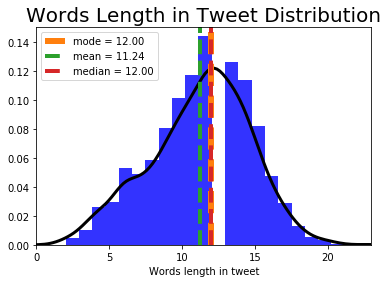

In [6]:
#Simple Explonatroy Data Analytics
#Draw the distribution for words in per tweet
train['comment_length'] = np.array(list(map(len, X_train_data)))
median = train['comment_length'].median()
mean = train['comment_length'].mean()
mode = train['comment_length'].mode()[0]

fig, ax = plt.subplots()
sb.distplot(train['comment_length'], bins=train['comment_length'].max(),
            hist_kws={"alpha": 0.8, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(train['comment_length'], 100))
ax.set_xlabel('Words length in tweet')
ymax = 0.15
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=6)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=4)
ax.set_title('Words Length in Tweet Distribution', fontsize=20)
plt.legend()
plt.show()

In [7]:
#-----Step3: Build the model---------------

In [9]:
#1. Build word vector (use gensim's word2vec model to build a word embedding)
#2. Use the word2vec model to define most similar words and calculate diffence between the words
#3. Use all the tweet content to build bigrams and trigrams
bigrams = Phrases(sentences=all_reviews)
trigrams = Phrases(sentences=bigrams[all_reviews])
embedding_vector_size = 256
trigrams_model = Word2Vec(
    sentences = trigrams[bigrams[all_reviews]],
    size = embedding_vector_size,
    min_count=3, window=5, workers=4)
print("Vocabulary size:", len(trigrams_model.wv.vocab))

#Define functions for later use!
def vectorize_data(data, vocab: dict) -> list:
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    return vectorized

Vocabulary size: 1660


In [ ]:
#Deal with X_training:trigram+vectorize
#Step1: Convert sentences to sentences with ngrams
X_data = trigrams[bigrams[X_train_data]]
MAX_REVIEW_LENGTH = 150
#Step2: Transform sentences to sequences
X_pad = pad_sequences(sequences=vectorize_data(X_data, vocab=trigrams_model.wv.vocab), maxlen=MAX_REVIEW_LENGTH, padding='post')

In [ ]:
#Split Data for later evlation use
X_train, X_test, y_train, y_test = train_test_split(X_pad, Y_train_data, test_size=0.05, shuffle=True, random_state=42)

The AUC socre for Logistic Regression model is : 0.5219.


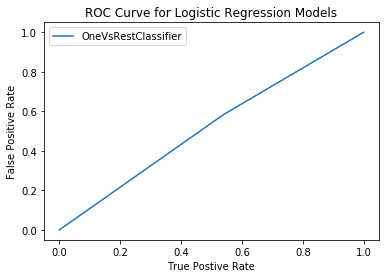

In [25]:
#-----Model Choice1: Logistic Regression---------------
#-------Train Model----------
logreg = LogisticRegression()
from sklearn.multiclass import OneVsRestClassifier
ovr = OneVsRestClassifier(logreg)
ovr.fit(X_train, y_train)
#--------Evaluation---------
y_test_pred_ovr = ovr.predict(X_test)
print("The AUC socre for Logistic Regression model is : %.4f." %roc_auc_score(y_test, y_test_pred_ovr))
y_pred_list = [y_test_pred_ovr]
label_list = ["OneVsRestClassifier"]
pred_label = zip(y_pred_list, label_list)
for y_pred, lbl in pred_label:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label = lbl)

plt.xlabel("True Postive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve for Logistic Regression Models")
plt.legend()
plt.show()

The AUC socre for Linear SVC model is : 0.5219.


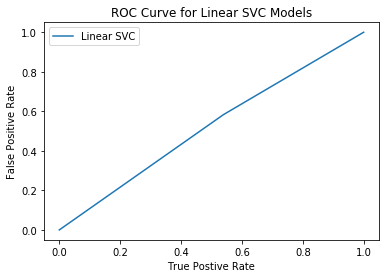

In [26]:
#-----Model Choice2: Linear SVC---------------
#-------Train Model----------
svc = LinearSVC(dual=False)
svc.fit(X_train, y_train)
#--------Evaluation---------
y_test_pred_svc = svc.predict(X_test)
print("The AUC socre for Linear SVC model is : %.4f." %roc_auc_score(y_test, y_test_pred_svc))
y_pred_list = [y_test_pred_svc]
label_list = ["Linear SVC"]
pred_label = zip(y_pred_list, label_list)
for y_pred, lbl in pred_label:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label = lbl)

plt.xlabel("True Postive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve for Linear SVC Models")
plt.legend()
plt.show()

In [10]:
#-----Model Choice3:RNN Model Architecture---------------
#-------------LSTM Model + GRU Model---------------
#Step1: Convert sentences to sentences with ngrams
X_data = trigrams[bigrams[X_train_data]]
MAX_REVIEW_LENGTH = 150

#Step2: Transform sentences to sequences
X_pad = pad_sequences(sequences=vectorize_data(X_data, vocab=trigrams_model.wv.vocab), maxlen=MAX_REVIEW_LENGTH, padding='post')

def build_model(embedding_matrix: np.ndarray, input_length: int,  use_lstm: bool):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    if use_lstm:
        model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    else:
        model.add(Bidirectional(GRU(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

lstm_model = build_model(embedding_matrix=trigrams_model.wv.vectors, input_length=MAX_REVIEW_LENGTH, use_lstm=True)
lstm_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
X_train, X_test, y_train, y_test = train_test_split(X_pad, Y_train_data, test_size=0.05, shuffle=True, random_state=42)
history = lstm_model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=100, epochs=20)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 256)          424960    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 835,713
Trainable params: 410,753
Non-trainable params: 424,960
__________________________________________

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 256)          424960    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               295680    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 737,153
Trainable params: 312,193
Non-trainable params: 424,960
__________________________________________

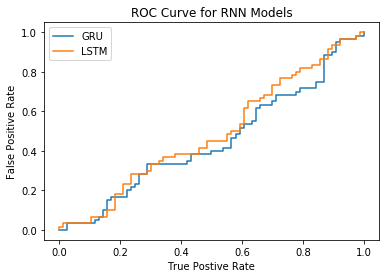

In [11]:
#---------------Evaluation: use accuracy + ROC-----------------
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from keras.layers import Input, Embedding, Dropout, Conv1D, MaxPool1D, GRU, LSTM, Dense

gru_model = build_model(embedding_matrix=trigrams_model.wv.vectors, input_length=MAX_REVIEW_LENGTH, use_lstm=False)
gru_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
gru_model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), batch_size=100, epochs=20)

y_test_pred_lstm = lstm_model.predict(X_test)
y_test_pred_gru = gru_model.predict(X_test)
print("The AUC socre for GRU model is : %.4f." %roc_auc_score(y_test, y_test_pred_gru))
print("The AUC socre for LSTM model is : %.4f." %roc_auc_score(y_test, y_test_pred_lstm))

y_pred_list = [y_test_pred_gru, y_test_pred_lstm]
label_list = ["GRU", "LSTM"]
pred_label = zip(y_pred_list, label_list)
for y_pred, lbl in pred_label:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label = lbl)

plt.xlabel("True Postive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve for RNN Models")
plt.legend()
plt.show()

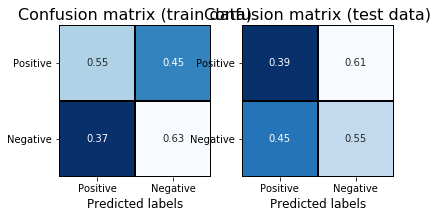

In [13]:
y_train_pred = lstm_model.predict_classes(X_train)
y_test_pred = lstm_model.predict_classes(X_test)

def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])


In [ ]:
#------< Last Setp: SVC Prediction for the Required Data>------------
all_submit_data = pd.read_csv('project_Data.csv')
tweet_submit= all_submit_data['tweet']
tweet_submit = np.array(list(map(lambda x: preprocess(x, len(tweet_submit)), tweet_submit)))
counter = 0
X_submission = trigrams[bigrams[tweet_submit]]
print('Convert sentences to sentences with ngrams... (done)')
X_submission_pad = pad_sequences(
    sequences=vectorize_data(X_submission, vocab=trigrams_model.wv.vocab),
    maxlen=MAX_REVIEW_LENGTH,
    padding='post')
print('Transform sentences to sequences... (done)')
predictions = svc.predict(X_submission_pad)
submission = pd.DataFrame()
submission['id'] = all_submit_data['id']
submission['sentiment_evaluation'] = abs(predictions-1)
submission['tweet']=all_submit_data['tweet']
submission.loc[submission.sentiment_evaluation ==0,'tweet'] = np.nan
print('accuracy for the submitted data is:',sum(submission['sentiment_evaluation'])/len(submission['sentiment_evaluation']))

In [49]:
#------< Last Setp: Logistic Regression Prediction for the Required Data>------------
all_submit_data = pd.read_csv('project_Data.csv')
tweet_submit= all_submit_data['tweet']
tweet_submit = np.array(list(map(lambda x: preprocess(x, len(tweet_submit)), tweet_submit)))
counter = 0
X_submission = trigrams[bigrams[tweet_submit]]
print('Convert sentences to sentences with ngrams... (done)')
X_submission_pad = pad_sequences(
    sequences=vectorize_data(X_submission, vocab=trigrams_model.wv.vocab),
    maxlen=MAX_REVIEW_LENGTH,
    padding='post')
print('Transform sentences to sequences... (done)')
predictions = ovr.predict(X_submission_pad)
submission = pd.DataFrame()
submission['id'] = all_submit_data['id']
submission['sentiment_evaluation'] = abs(predictions-1)
submission['tweet']=all_submit_data['tweet']
submission.loc[submission.sentiment_evaluation ==0,'tweet'] = np.nan
print('accuracy for the submitted data is:',sum(submission['sentiment_evaluation'])/len(submission['sentiment_evaluation']))

Convert sentences to sentences with ngrams... (done)
Transform sentences to sequences... (done)
accuracy for the submitted data is: 0.45115257958287597


In [52]:
#------< Last Setp: Prediction for the Required Data>------------
all_submit_data = pd.read_csv('project_Data.csv')
tweet_submit= all_submit_data['tweet']
tweet_submit = np.array(list(map(lambda x: preprocess(x, len(tweet_submit)), tweet_submit)))
counter = 0
X_submission = trigrams[bigrams[tweet_submit]]
print('Convert sentences to sentences with ngrams... (done)')
X_submission_pad = pad_sequences(
    sequences=vectorize_data(X_submission, vocab=trigrams_model.wv.vocab),
    maxlen=MAX_REVIEW_LENGTH,
    padding='post')
print('Transform sentences to sequences... (done)')

predictions = lstm_model.predict_classes(X_submission_pad)

submission = pd.DataFrame()
submission['id'] = all_submit_data['id']
submission['sentiment_evaluation'] = abs(predictions-1)
submission['tweet']=all_submit_data['tweet']
submission.loc[submission.sentiment_evaluation ==0,'tweet'] = np.nan
print('the final accuracy for the submitted data is:',sum(submission['sentiment_evaluation'])/len(submission['sentiment_evaluation']))

Convert sentences to sentences with ngrams... (done)
Transform sentences to sequences... (done)
the final accuracy for the submitted data is: 0.49176728869374314


In [54]:
submission.to_csv('submission_DeepLearning.csv',index=False)